# Import Dataset

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

file_path = 'Obfuscated-MalMem2022.csv'
df = pd.read_csv(file_path)
df['Category'] = df['Category'].str.extract(r'(-[^-\s]+|Benign)')

# Attempt ML with Categorical Labels
### Feature Engineering before modeling

In [63]:
# Fill blanks with median
for col in df.columns:
    if df[col].dtype == np.number:
        df[col].fillna(df[col].median(), inplace=True)

C:\Users\shane\AppData\Local\Temp\ipykernel_42096\3644885481.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if df[col].dtype == np.number:


In [64]:
# one hot encoding
df = pd.get_dummies(df, drop_first=True, columns=['Category'])
#drop duplicates 
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows to be dropped: {num_duplicates}")
df = df.drop_duplicates()

Number of duplicate rows to be dropped: 549


In [68]:
# Check for no variation in columns
zero_std_columns = [col for col in df.columns if df[col].dtype != object and df[col].std() == 0]
if len(zero_std_columns) > 0:
    print("Columns without variation:", ', '.join(zero_std_columns))
else:
    print("There are no columns without variation.")


Columns without variation: pslist.nprocs64bit, handles.nport, svcscan.interactive_process_services


In [59]:
columns_to_drop = ['pslist.nprocs64bit', 'handles.nport', 'svcscan.interactive_process_services']
df = df.drop(columns=columns_to_drop)

In [60]:
print("\nClass counts for 'Class':")
print(df['Class'].value_counts())



Class counts for 'Category':


KeyError: 'Category'

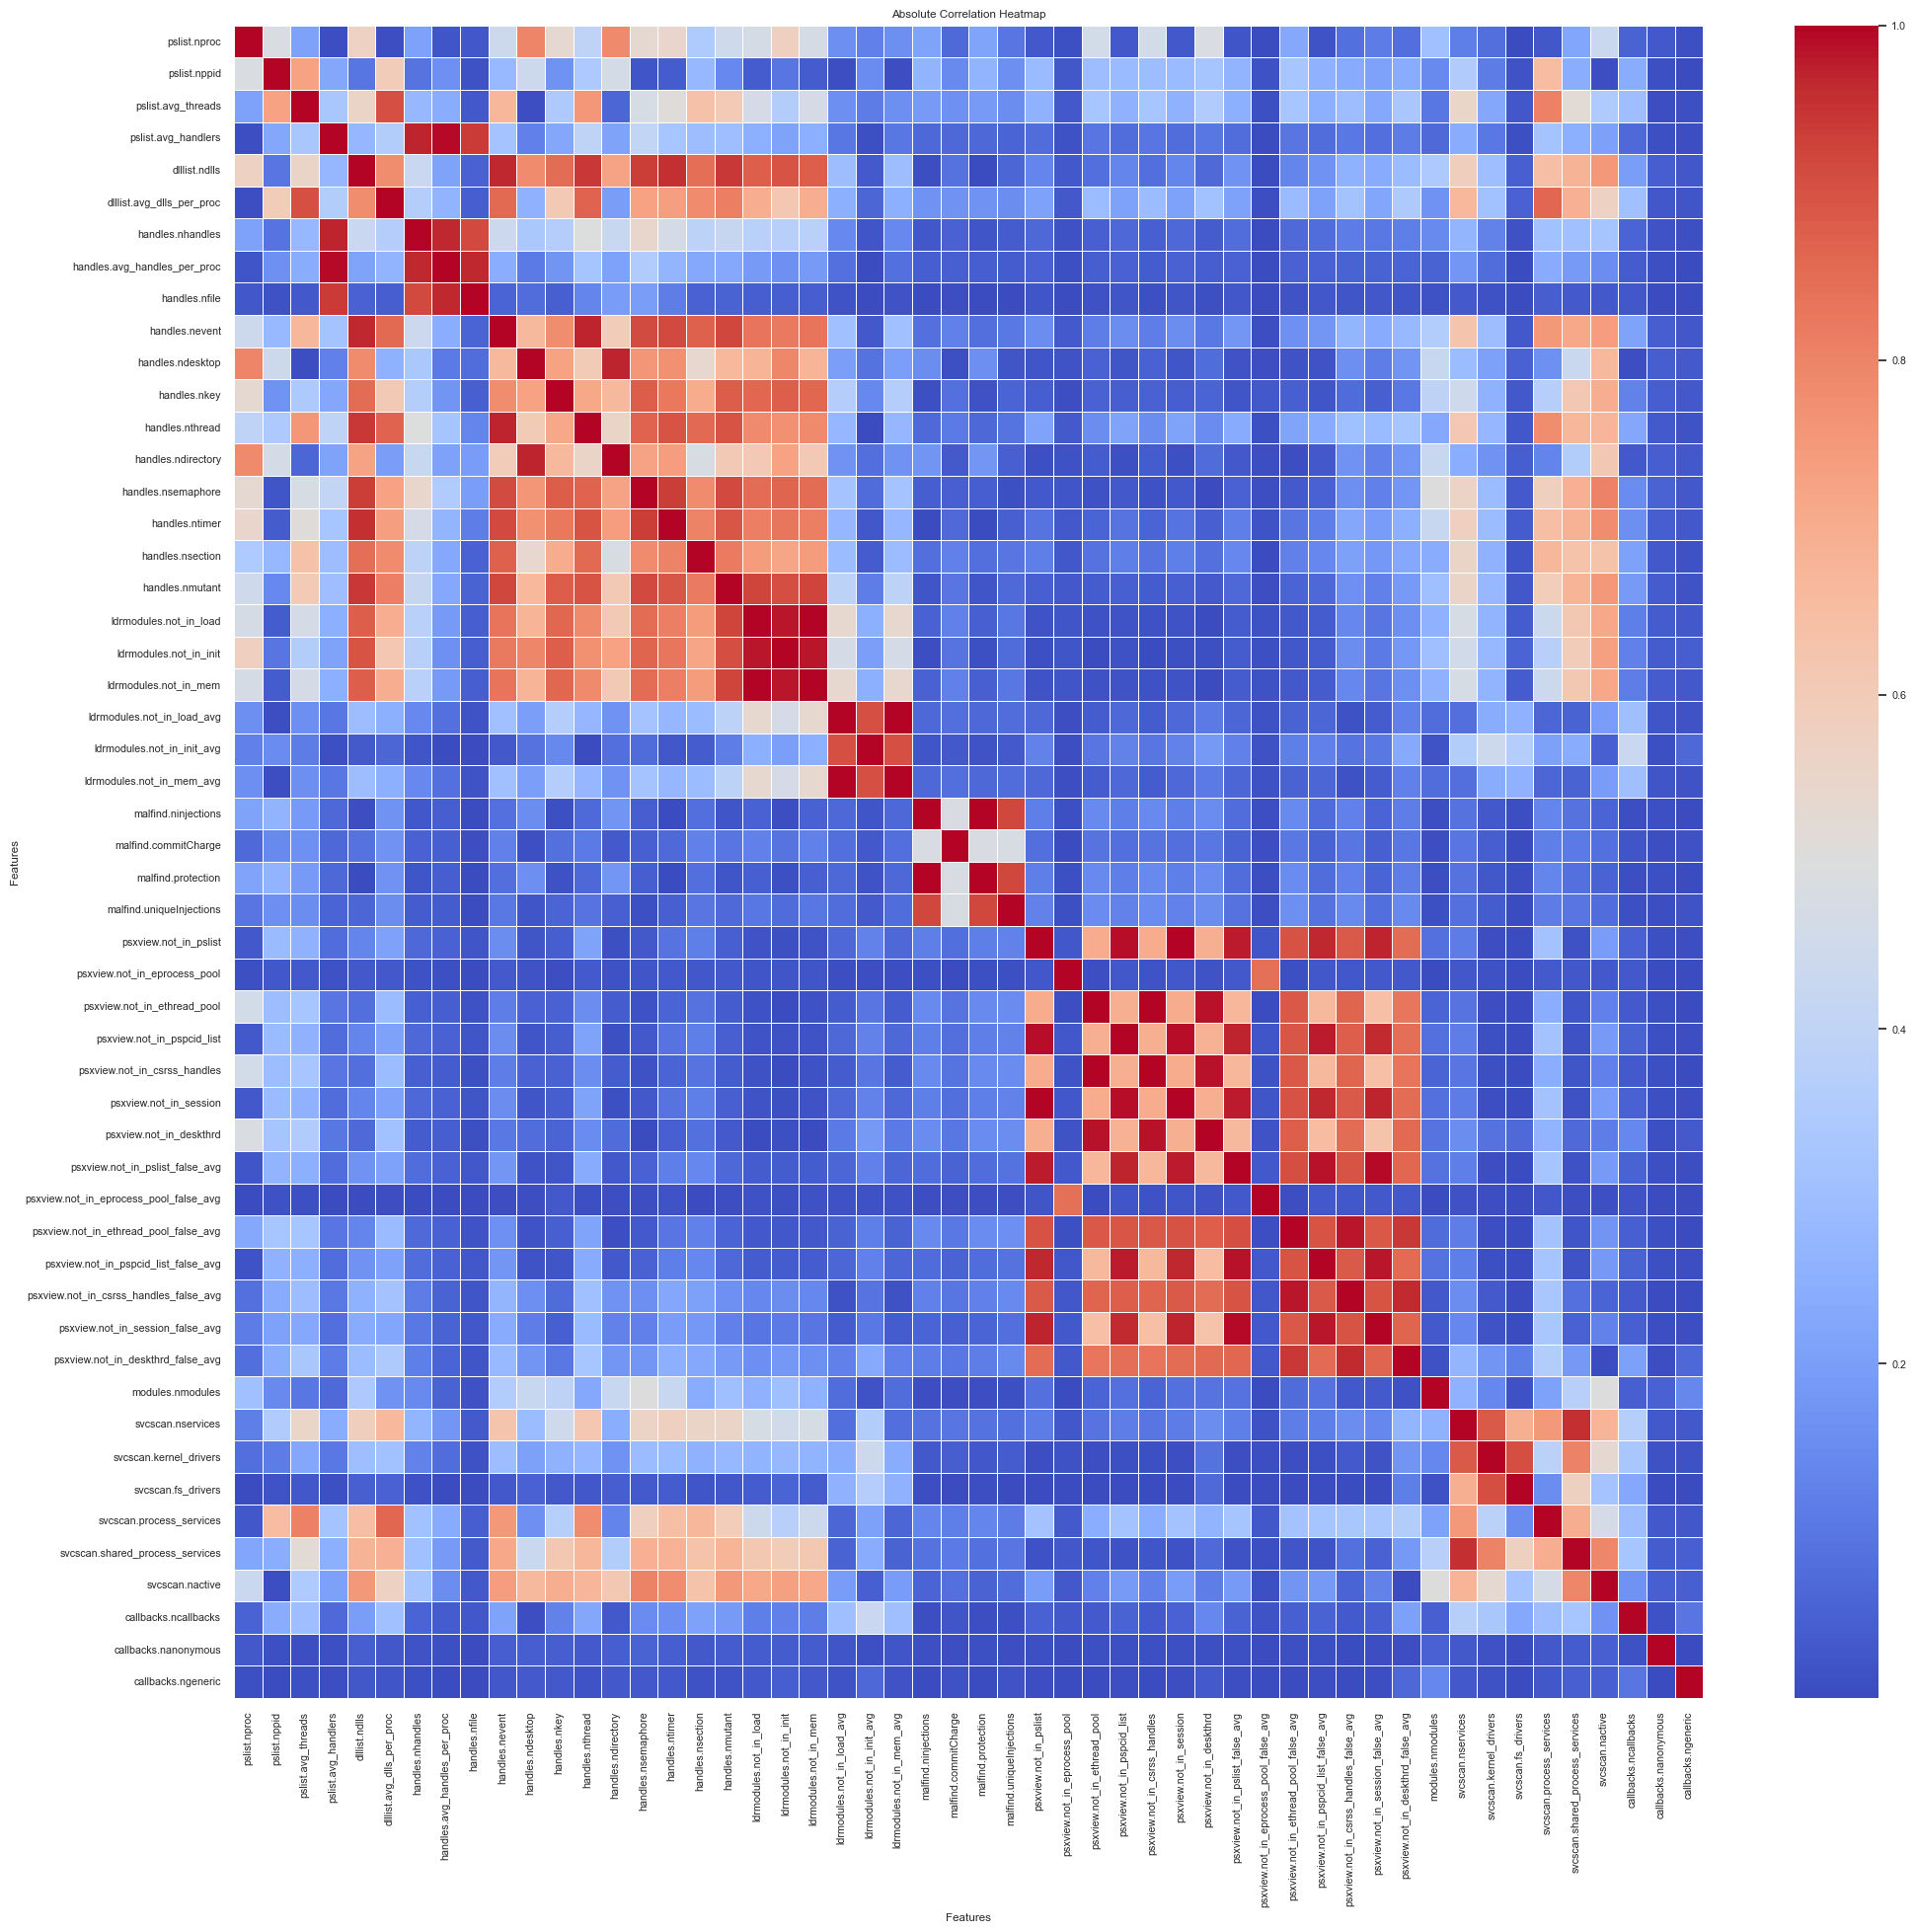

In [29]:
import seaborn as sns
import numpy as np

corr_matrix_abs = np.abs(df.corr())
plt.figure(figsize=(24, 22))
sns.set(font_scale=0.7)
sns.heatmap(corr_matrix_abs, annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Absolute Correlation Heatmap")
plt.xlabel("Features")
plt.ylabel("Features")
plt.savefig("absolute_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
high_corr = corr_matrix_abs[(corr_matrix_abs > 0.9) & (corr_matrix_abs < 1.0)]

print("Feature pairs with absolute correlation above 0.9:\n")
for i in high_corr.index:
    for j in high_corr.columns:
        if not np.isnan(high_corr.at[i, j]):
            print(f"{i} - {j}: {high_corr.at[i, j]}")

Feature pairs with absolute correlation above 0.9:

pslist.avg_threads - dlllist.avg_dlls_per_proc: 0.9049146894956439
pslist.avg_handlers - handles.nhandles: 0.9715572523143977
pslist.avg_handlers - handles.avg_handles_per_proc: 0.9925404146478263
pslist.avg_handlers - handles.nfile: 0.9400252155651362
dlllist.ndlls - handles.nevent: 0.9664313711683106
dlllist.ndlls - handles.nthread: 0.9421596210274564
dlllist.ndlls - handles.nsemaphore: 0.9361041839308485
dlllist.ndlls - handles.ntimer: 0.9541860368154251
dlllist.ndlls - handles.nmutant: 0.9417743502722977
dlllist.avg_dlls_per_proc - pslist.avg_threads: 0.9049146894956439
handles.nhandles - pslist.avg_handlers: 0.9715572523143977
handles.nhandles - handles.avg_handles_per_proc: 0.9670021394151382
handles.nhandles - handles.nfile: 0.9166174994513288
handles.avg_handles_per_proc - pslist.avg_handlers: 0.9925404146478263
handles.avg_handles_per_proc - handles.nhandles: 0.9670021394151382
handles.avg_handles_per_proc - handles.nfile: 0.

# PCA

In [52]:
from sklearn.model_selection import train_test_split

df_category = df.drop(columns=['Class'])
print(df['Category'].value_counts())

X = df_category.drop(columns=['Category'])
y = df_category['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_components = 2
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Transponder     2410
Gator           2200
Shade           2128
Ako             2000
180solutions    2000
CWS             2000
Refroso         2000
Scar            2000
Conti           1988
Emotet          1967
Maze            1958
Zeus            1950
Pysa            1717
Reconyc         1570
TIBS            1410
Name: Category, dtype: int64
Explained variance ratio: [0.52679876 0.44673175]


# Random Forest with Cross Validation
### (PCA hurt results)

In [54]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, make_scorer

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

f1_scorer = make_scorer(f1_score, average='weighted')

accuracy_scores = cross_val_score(clf, X_train, y_train_encoded, cv=5)
f1_scores = cross_val_score(clf, X_train, y_train_encoded, cv=5, scoring=f1_scorer)

print("Accuracy scores:", accuracy_scores)
print("Mean accuracy score:", np.mean(accuracy_scores))
print("F1 scores:", f1_scores)
print("Mean F1 score:", np.mean(f1_scores))

clf.fit(X_train, y_train_encoded)

y_pred_encoded = clf.predict(X_test)
y_test_str = y_test.astype(str)
y_pred_str = [str(y) for y in y_pred]

report = classification_report(y_test_str, y_pred_str, output_dict=True)

for class_name, metrics in report.items():
    if class_name != "accuracy" and class_name != "macro avg" and class_name != "weighted avg":
        print(f"{class_name}: {metrics['precision']}")


Accuracy scores: [0.74573379 0.74826667 0.75381333 0.75445333 0.75349333]
Mean accuracy score: 0.7511520910125142
F1 scores: [0.74386924 0.74709897 0.75216564 0.75283213 0.751826  ]
Mean F1 score: 0.7495583944419791
180solutions: 0.4514285714285714
Ako: 0.37777777777777777
CWS: 0.4137055837563452
Conti: 0.45528455284552843
Emotet: 0.5109289617486339
Gator: 0.5650485436893203
Maze: 0.5459183673469388
Pysa: 0.42900302114803623
Reconyc: 0.6114285714285714
Refroso: 0.745920745920746
Scar: 0.535181236673774
Shade: 0.4681372549019608
TIBS: 0.8068181818181818
Transponder: 0.4758909853249476
Zeus: 0.434878587196468
nan: 0.9994821336095288


### Grid Search

In [49]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

clf = RandomForestClassifier(random_state=100

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

grid_search.fit(X_train_pca, y_train_encoded)

print("Best hyperparameters:", grid_search.best_params_)
print("Best accuracy score:", grid_search.best_score_)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best hyperparameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best accuracy score: 0.6355064823663253


In [51]:
from sklearn.metrics import classification_report

clf.fit(X_train_pca, y_train_encoded)

y_pred_encoded = clf.predict(X_test_pca)

y_pred = encoder.inverse_transform(y_pred_encoded)

report = classification_report(y_test, y_pred, output_dict=True)

for class_name, metrics in report.items():
    if class_name != "accuracy" and class_name != "macro avg" and class_name != "weighted avg":
        print(f"{class_name}: {metrics['precision']}")


TypeError: '<' not supported between instances of 'float' and 'str'